In [1]:
import pandas as pd
diabetes = pd.read_csv('diabetes.csv')

In [2]:
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
target = 'Diabetic'
X, y = diabetes[features], diabetes[target]

In [3]:
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[['Pregnancies', 'Age']], y, test_size=0.30, random_state=0, stratify=y)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

In [5]:
from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score

In [6]:
import matplotlib.pyplot as plt

In [7]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
def calculate_metrics(model, name, X_checked, y_checked, specifics):
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    
    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()
    plt.close() 

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, thresholds = roc_curve(y_checked, predictions_proba[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    plt.close()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    new_row = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric],
                            'C': [specifics[0]], 'Penalty': [specifics[1]], 'Class Weight': [specifics[2]]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    return metrics_dataframe

In [8]:
def plot_classification_surface(X_plot, y_plot, trained_model):
    plt.figure(figsize=(12, 7))

    # określenie granic zbioru
    min1, max1 = X_plot[:, 0].min()-1, X_plot[:, 0].max()+1
    min2, max2 = X_plot[:, 1].min()-1, X_plot[:, 1].max()+1

    # skalowanie dla obu osi
    x1grid = arange(min1, max1, 0.1)
    x2grid = arange(min2, max2, 0.1)

    # utworzenie siatki (tła, które jest przecięte wpół)
    xx, yy = meshgrid(x1grid, x2grid)

    # przetworzenie siatki w wektor
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # stworzenie zmiennych objaśniających dla modelu
    grid = hstack((r1,r2))

    # predykcja modelu zbioru
    yhat = trained_model.predict(grid)

    # przetworzenie predykcji na decyzji dla konkretnego punktu wykresu
    zz = yhat.reshape(xx.shape)

    # wizualizacja siatki z przyporządkowaną klasą
    plt.contourf(xx, yy, zz, cmap='Paired')

    # tworzenie wykresu punktowego dla klas ze zbioru X
    for class_value in range(2):

        # przyporządkowanie klasy (y) do obsewacji (X)
        row_ix = where(y_plot == class_value)

        # stworzenie wykresu punktowego
        plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)

    # wizualizacja wykresu
    plt.legend(loc='upper right')
    plt.show()

Opis zmienianych parametrów:

1. Parametr C (siła regularyzacji)
Duże wartości C (np. 10, 100): Model mniej reguluje, bardziej dopasowuje się do danych (ryzyko przeuczenia).
Małe wartości C (np. 0.01, 0.1): Silniejsza regularyzacja, co może uprościć model i zmniejszyć ryzyko przeuczenia (niedopasowanie).

2. Parametr penalty (rodzaj regularyzacji)
Opcje:
'l2': Domyślna regularyzacja.
'l1': Regularyzacja Lasso.
'elasticnet': Połączenie L1 i L2.
'none': Bez regularyzacji (ryzyko przeuczenia).

Jeśli masz dużo cech, a tylko niektóre są istotne, użyj L1.
Jeśli chcesz wyważyć L1 i L2, użyj ElasticNet.

3. Parametr class_weight (ważenie klas)
Ważenie klas w przypadku niezbalansowanych danych.
Opcje:
'balanced': Automatycznie ustawia wagi odwrotnie proporcjonalne do częstości występowania klas.
None: Domyślnie wszystkie klasy mają tę samą wagę.
Jak działa:
Jeśli Twoje dane mają znacznie więcej próbek jednej klasy niż drugiej, użycie 'balanced' poprawi wyniki dla mniej licznej klasy.

In [9]:
C_values = [0.01, 0.1, 1, 10, 100]
penalties = ['l1', 'l2']
class_weights = ['balanced', None]

our_models = []

for C in C_values:
    for penalty in penalties:
        for class_weight in class_weights:
            if penalty == 'l1':
                solver = 'liblinear'
            else:
                solver = 'lbfgs'

            
            model = LogisticRegression(C=C, penalty=penalty, class_weight=class_weight, 
                                        solver=solver, max_iter=1000)
            model.fit(X_train_standardized, y_train)
            specifics=[C,penalty,class_weight]
            our_models.append([model,specifics])

Our model: [0.01, 'l1', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.74      0.71      0.71      4500



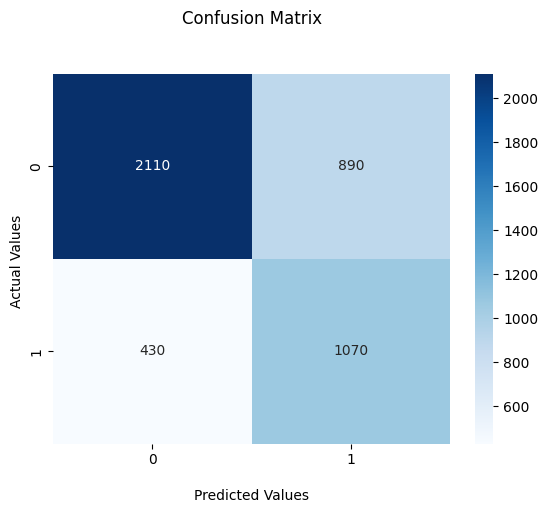

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


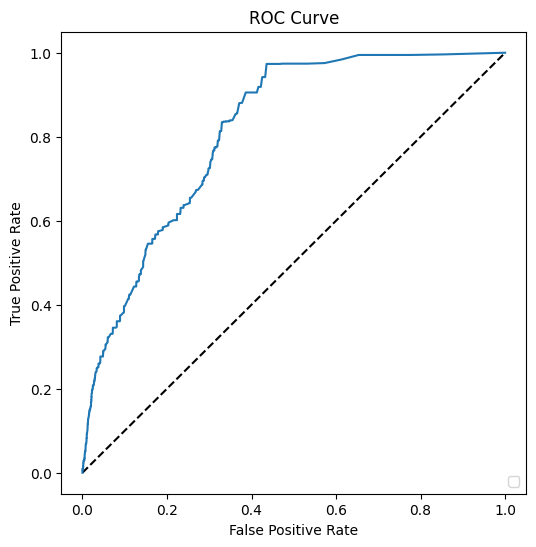

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


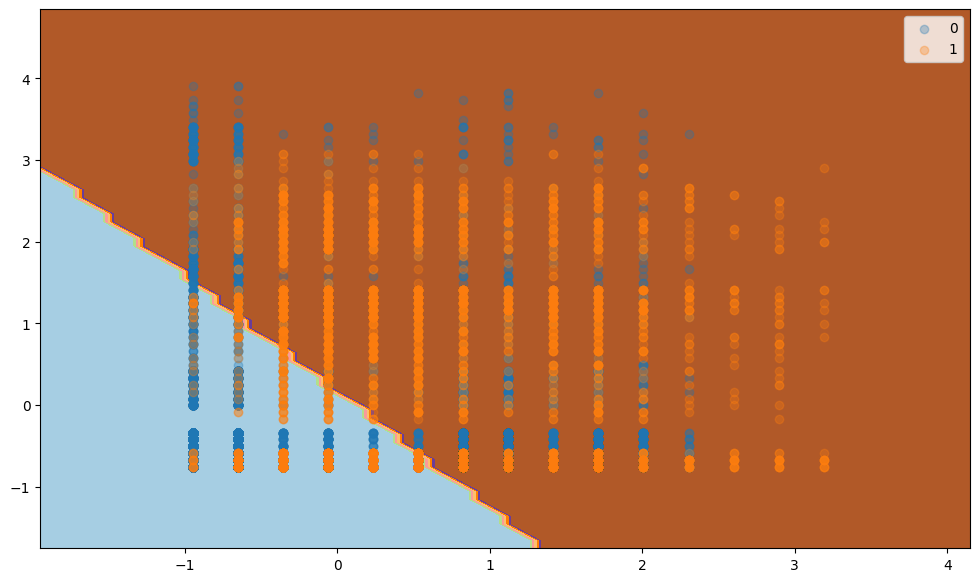

 
Our model: [0.01, 'l1', None]
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.74      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.74      0.74      4500



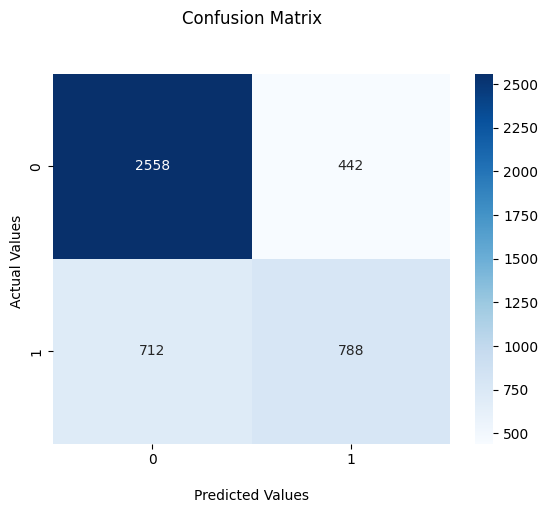

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


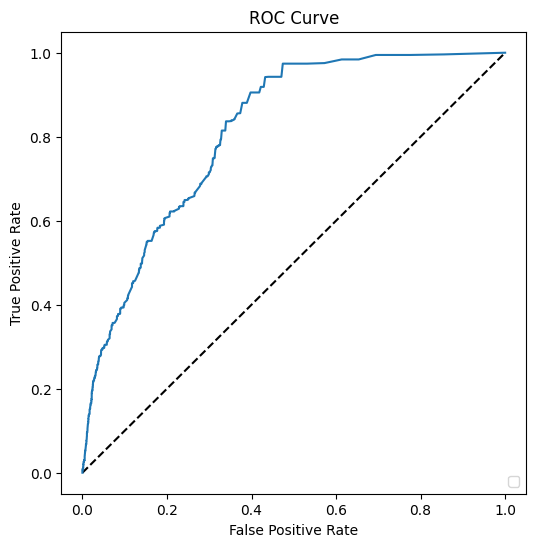

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


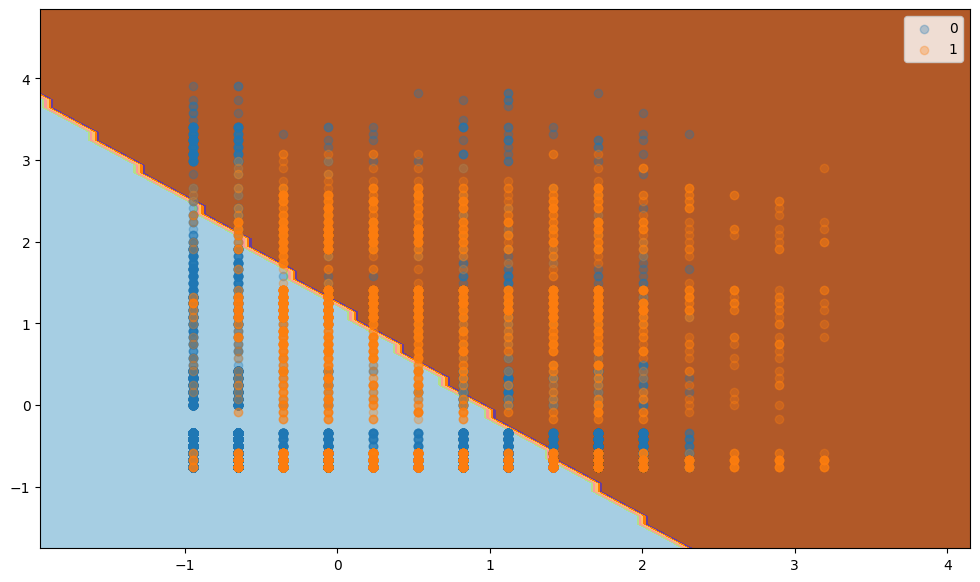

 
Our model: [0.01, 'l2', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



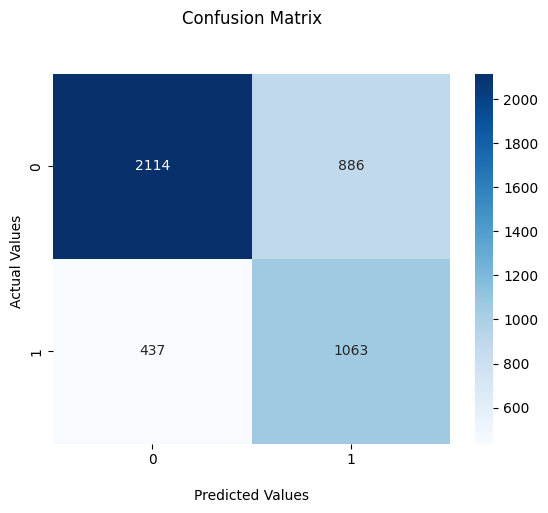

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


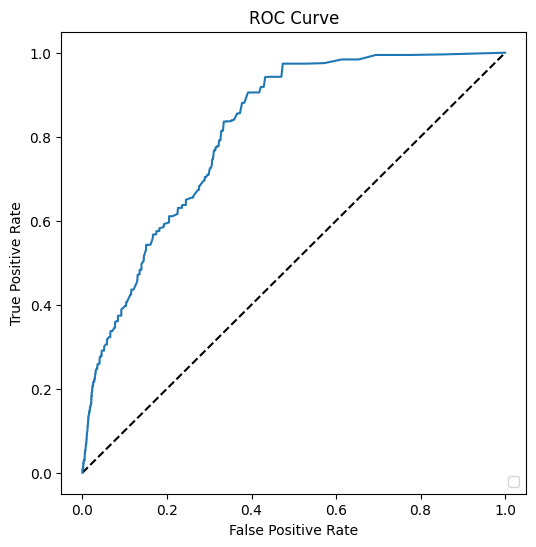

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


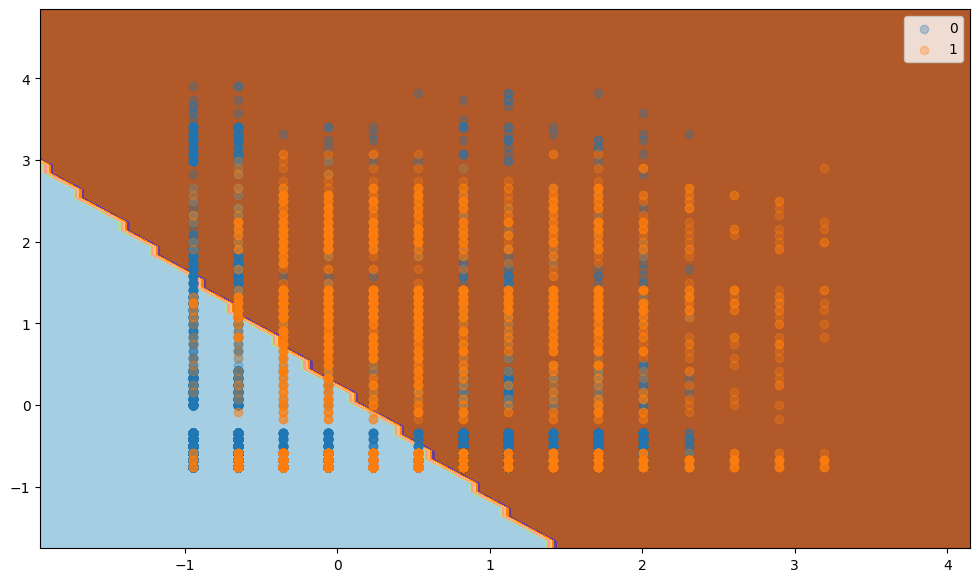

 
Our model: [0.01, 'l2', None]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      3000
           1       0.64      0.51      0.57      1500

    accuracy                           0.74      4500
   macro avg       0.71      0.68      0.69      4500
weighted avg       0.73      0.74      0.73      4500



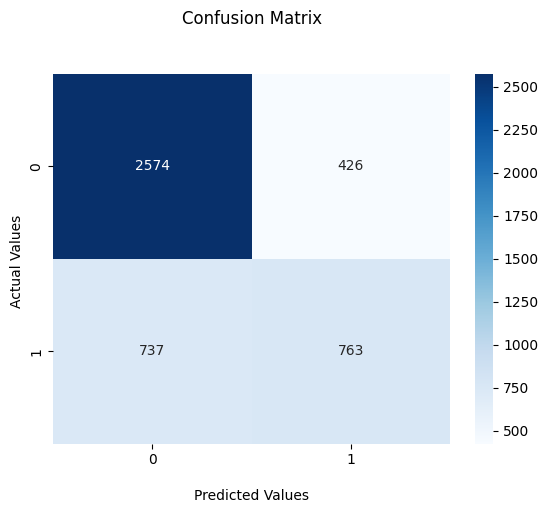

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


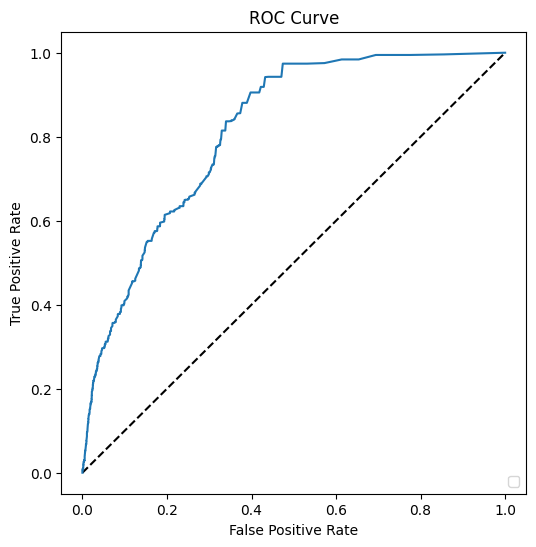

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


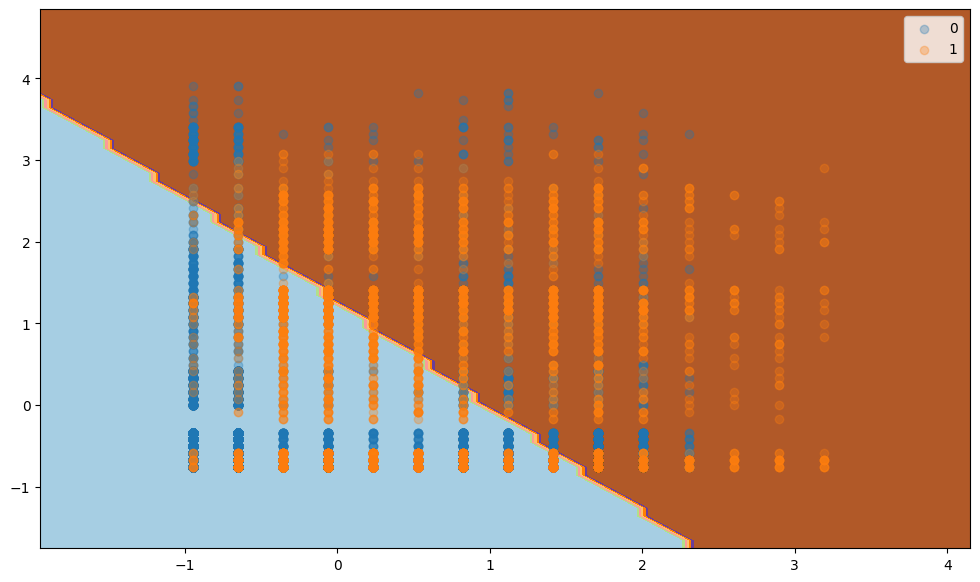

 
Our model: [0.1, 'l1', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



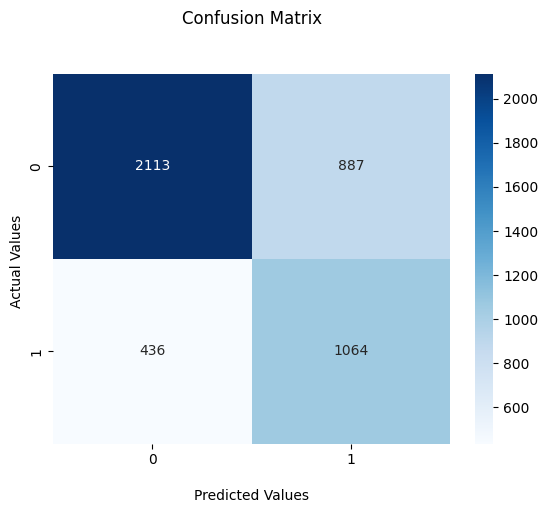

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


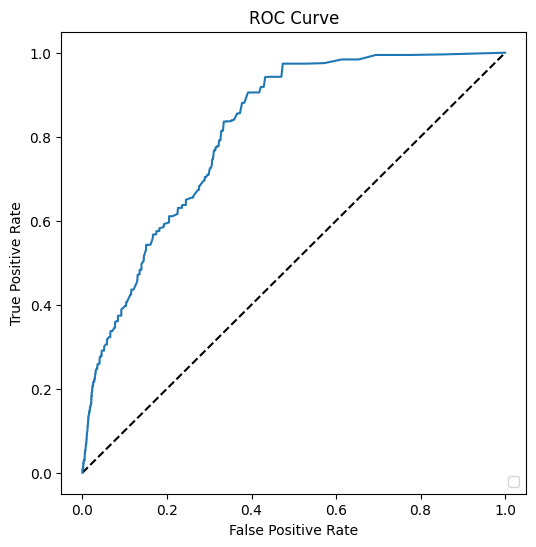

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


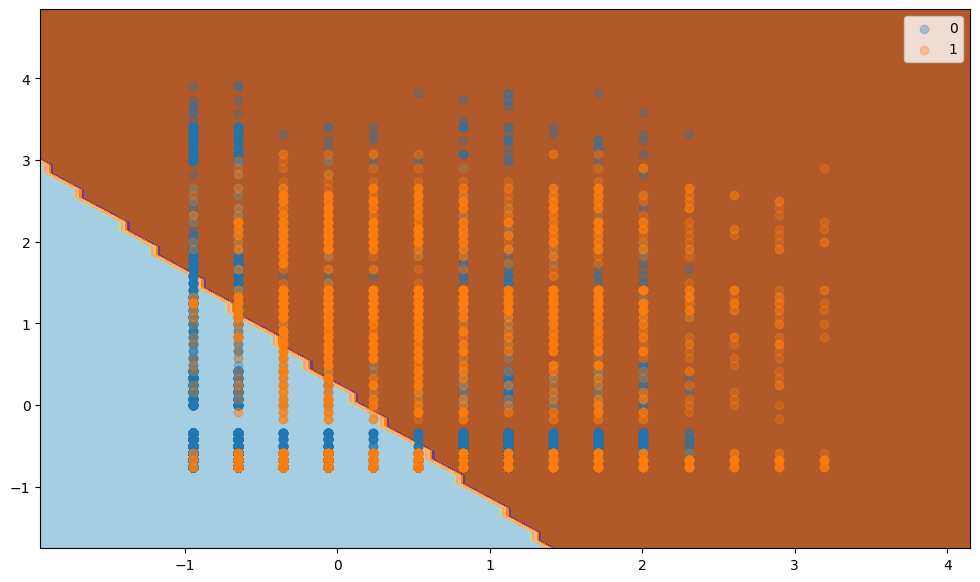

 
Our model: [0.1, 'l1', None]
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



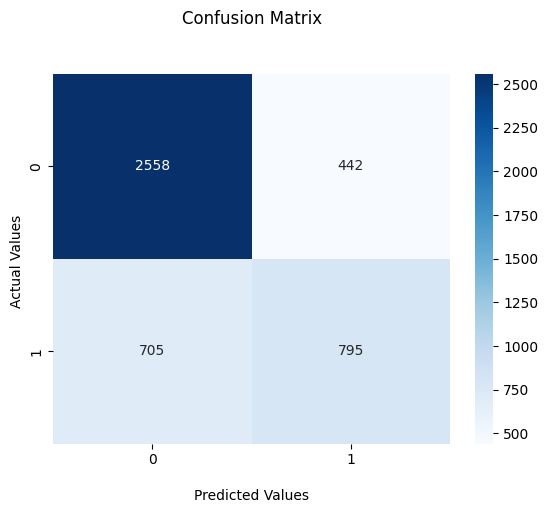

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


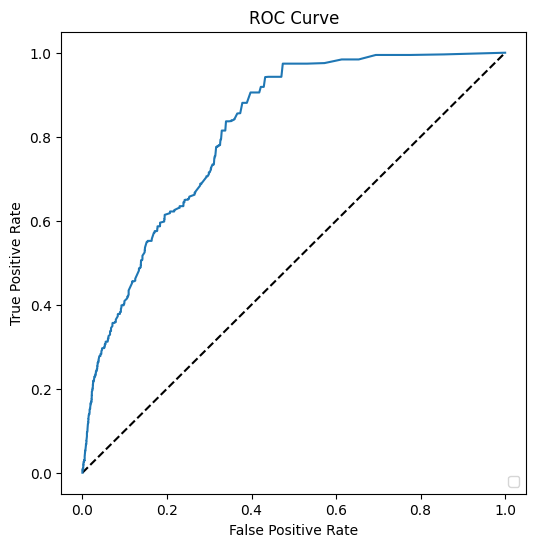

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


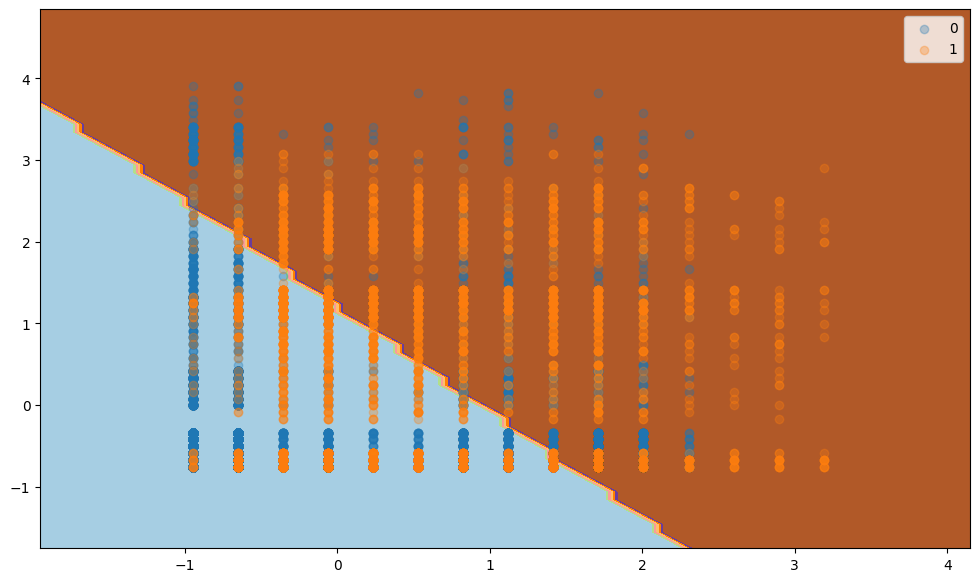

 
Our model: [0.1, 'l2', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



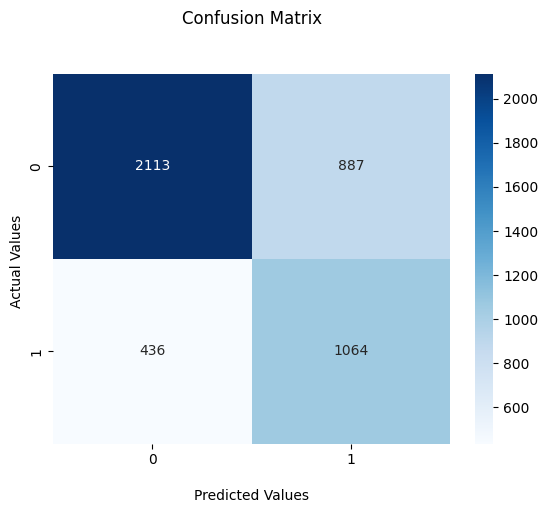

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


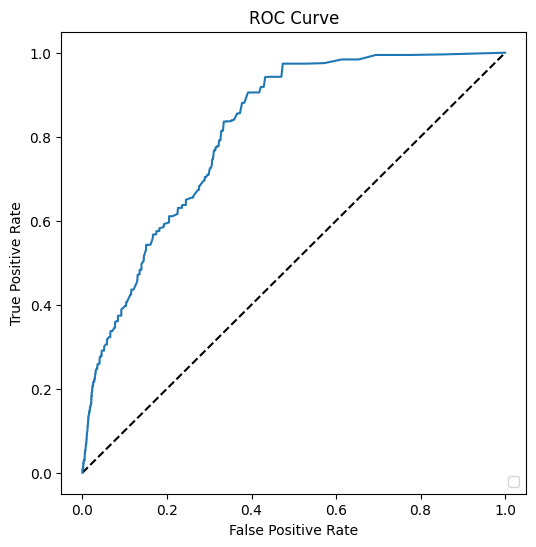

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


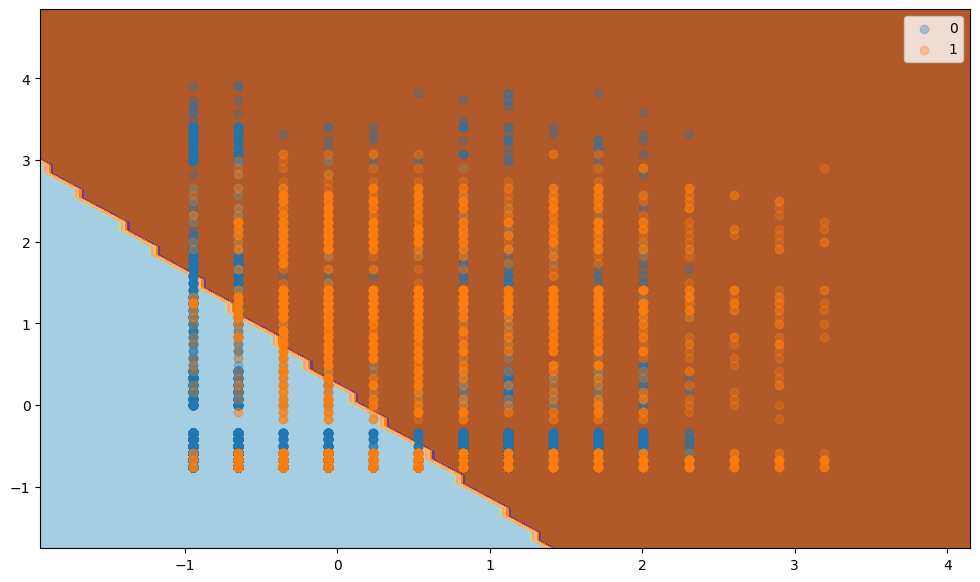

 
Our model: [0.1, 'l2', None]
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.74      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.74      0.74      4500



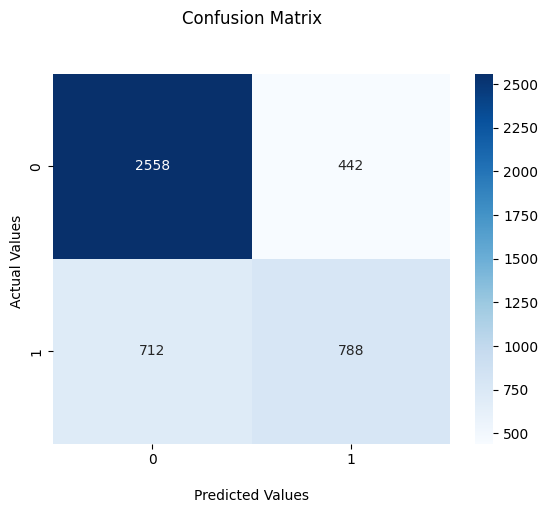

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


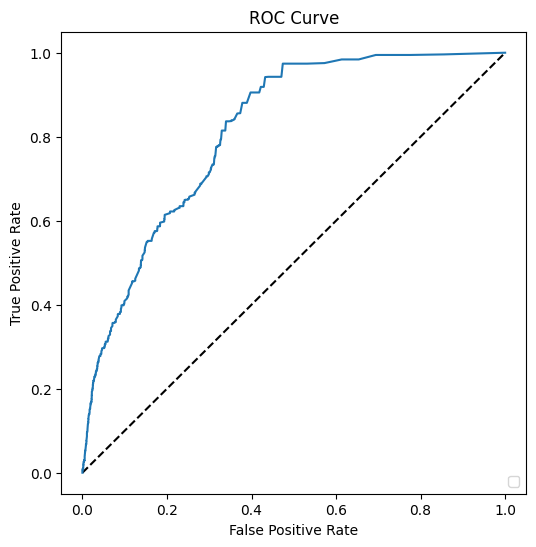

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


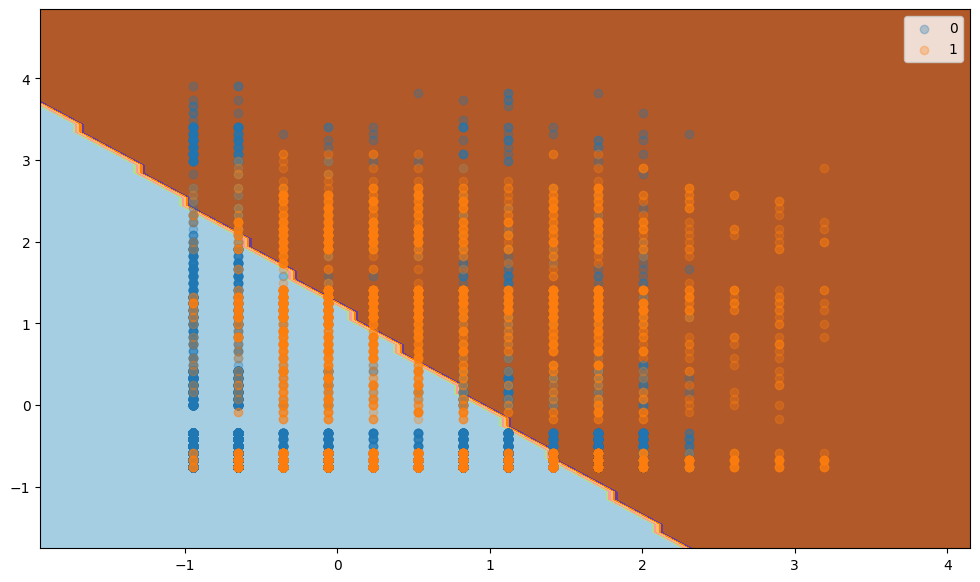

 
Our model: [1, 'l1', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



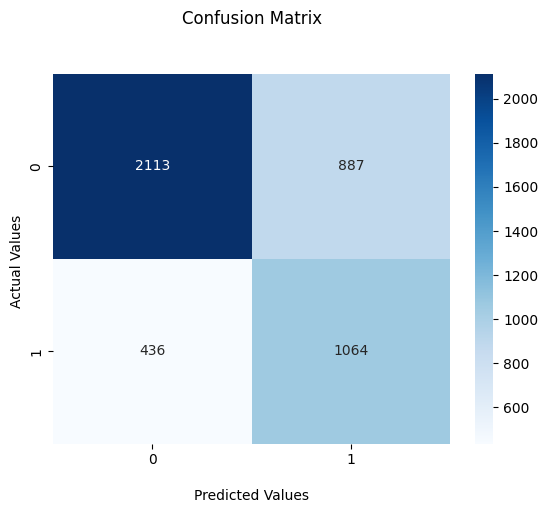

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


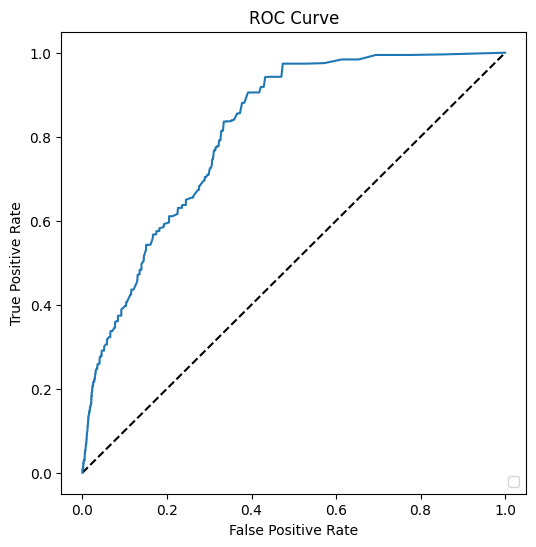

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


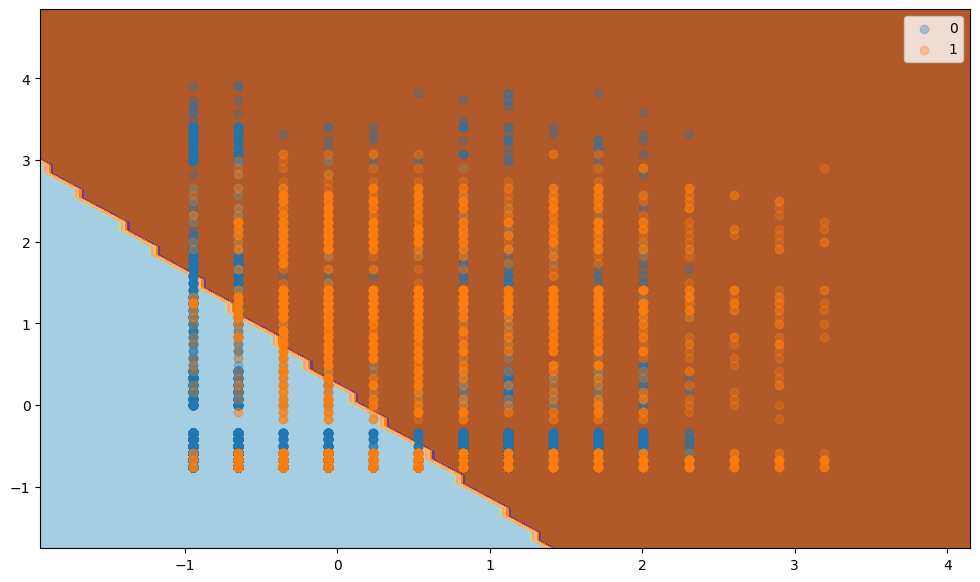

 
Our model: [1, 'l1', None]
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



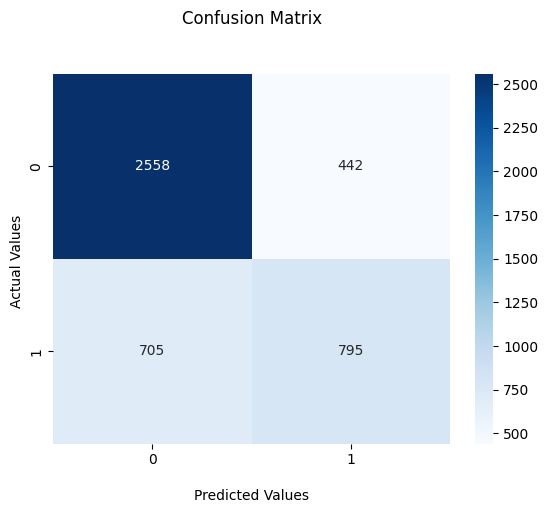

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


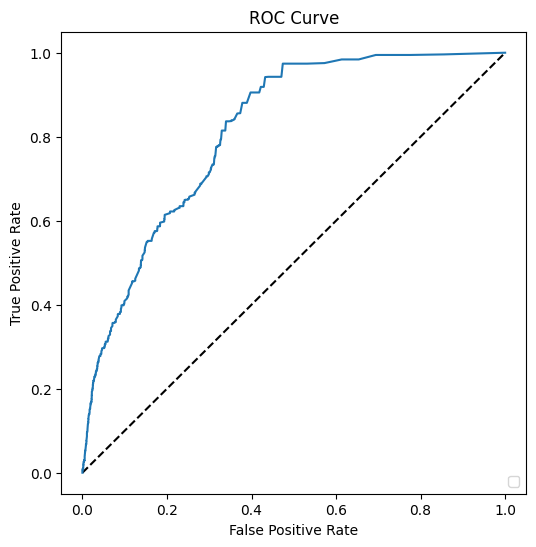

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


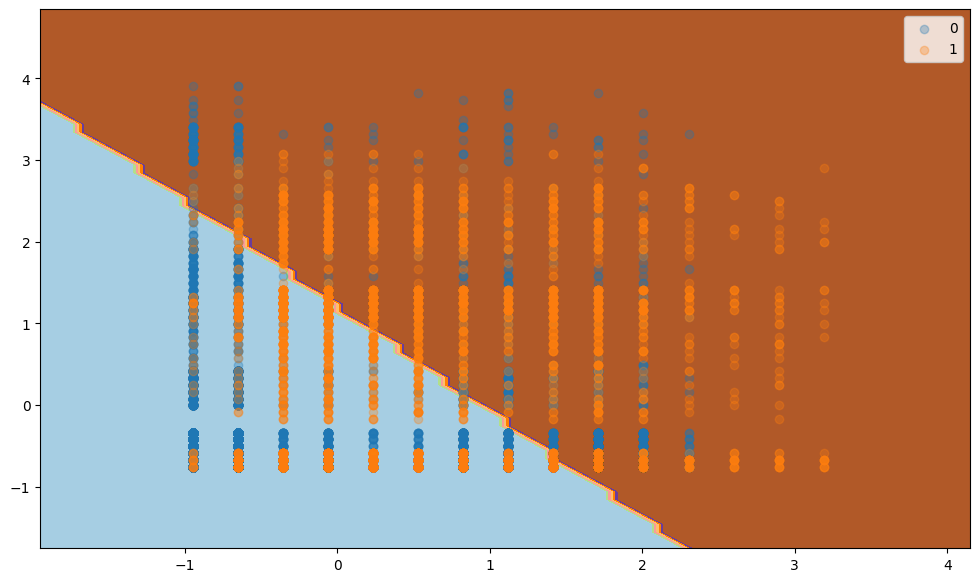

 
Our model: [1, 'l2', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



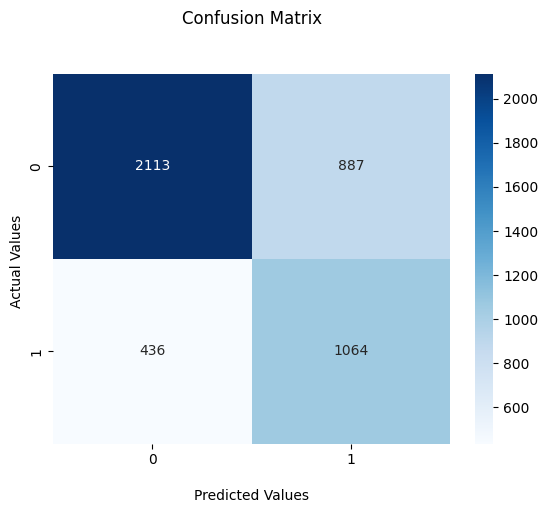

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


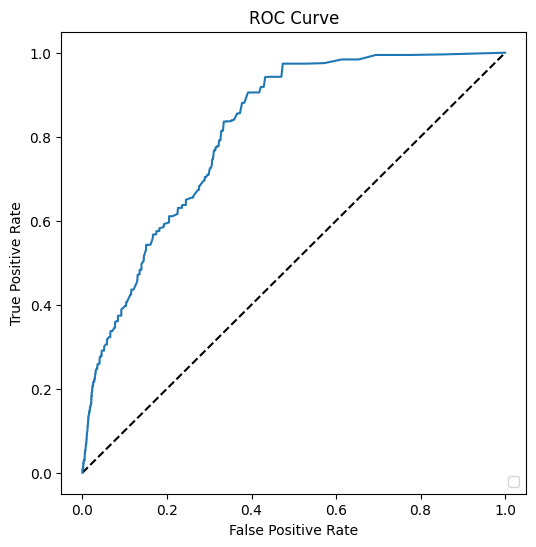

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


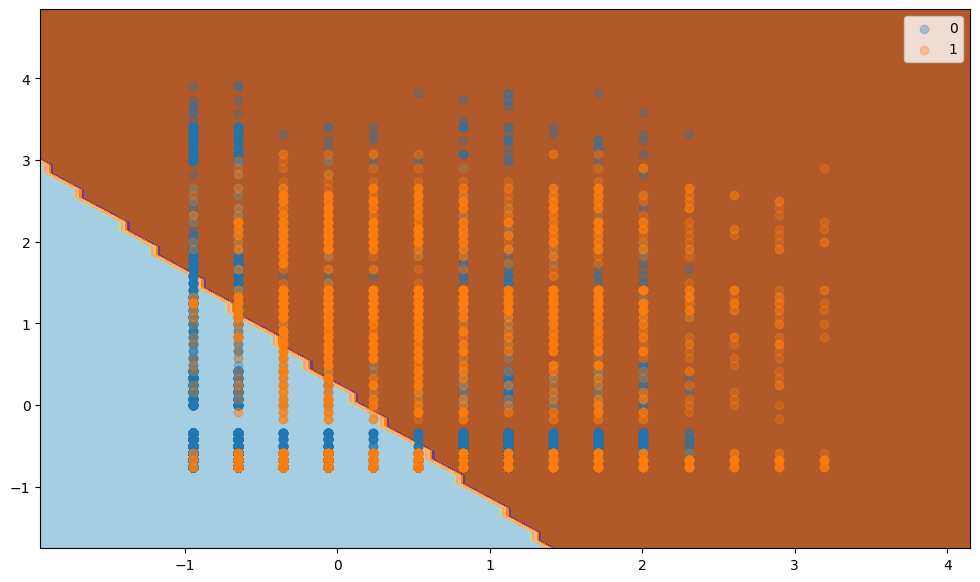

 
Our model: [1, 'l2', None]
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



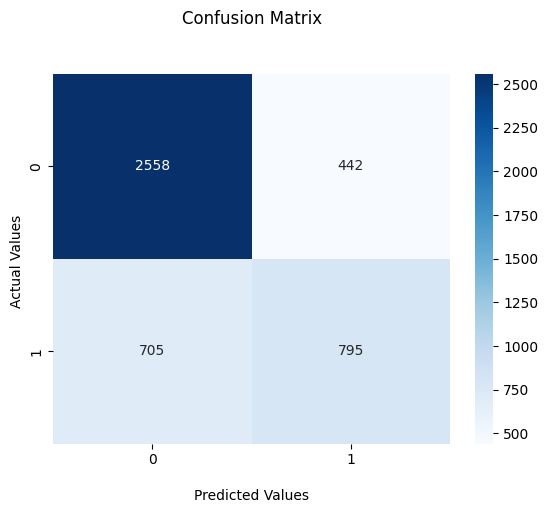

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


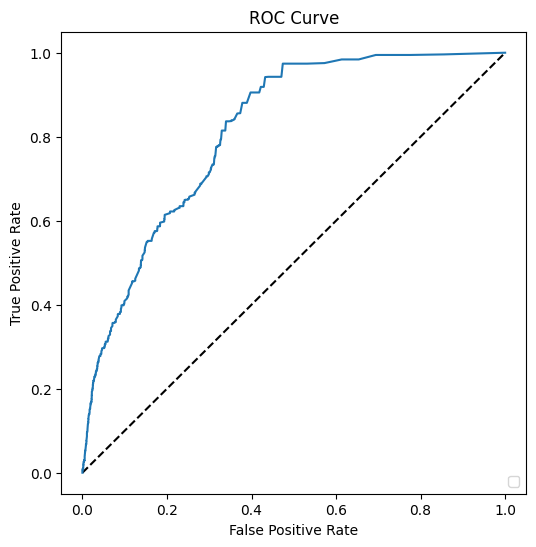

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


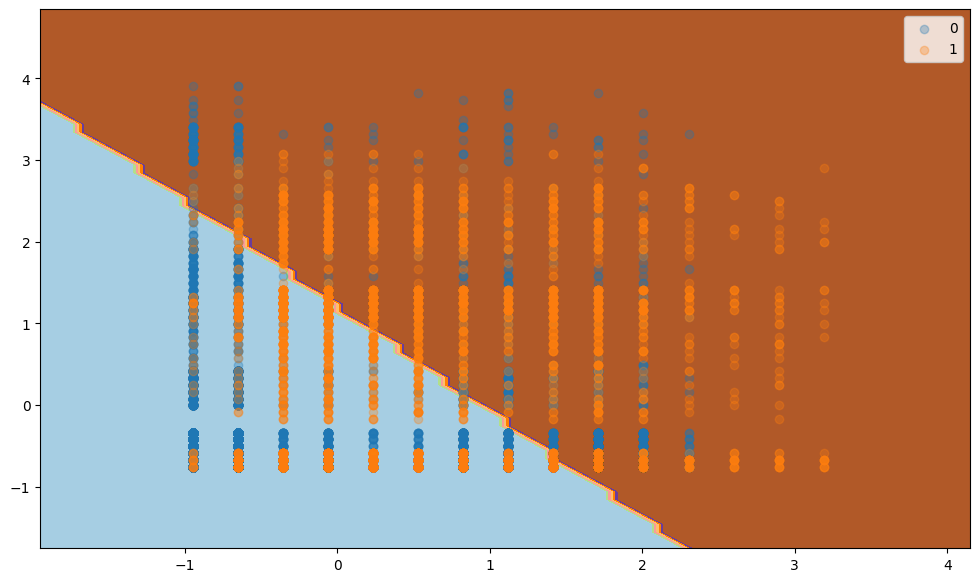

 
Our model: [10, 'l1', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



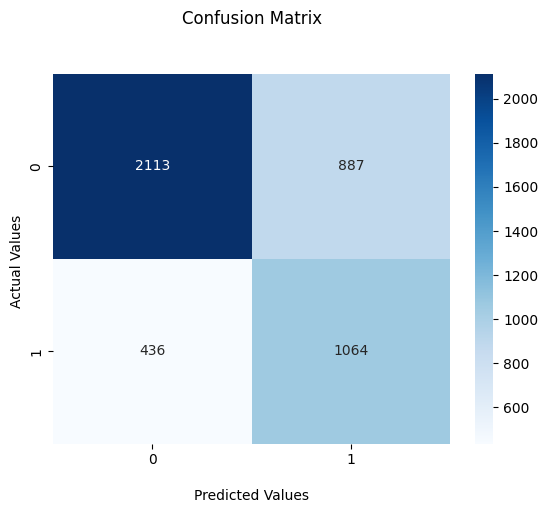

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


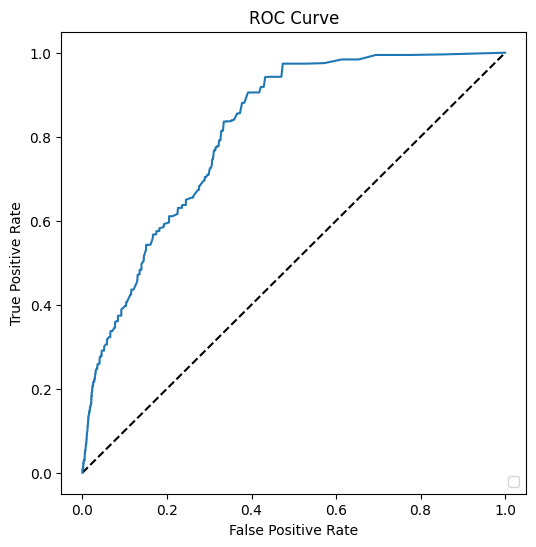

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


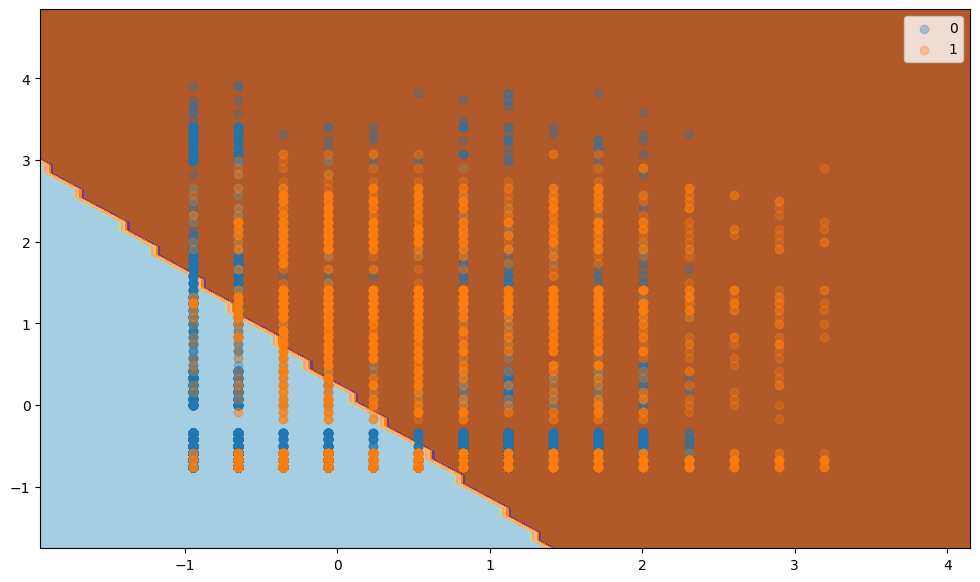

 
Our model: [10, 'l1', None]
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



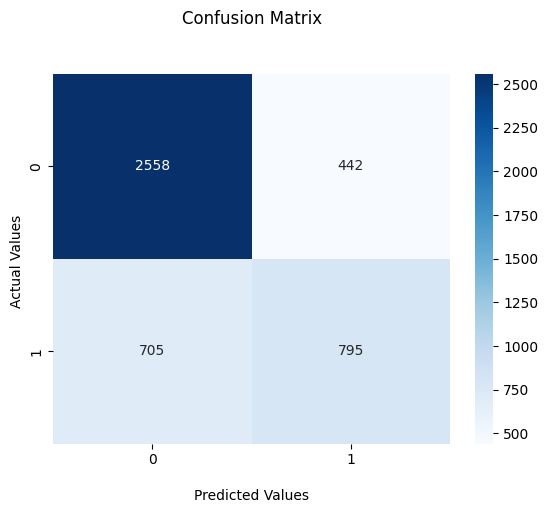

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


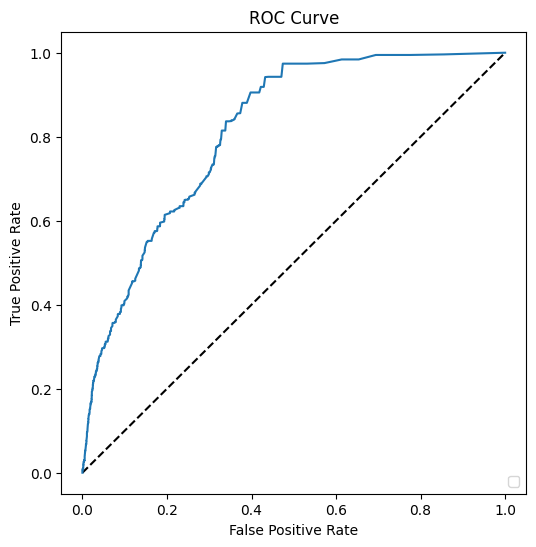

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


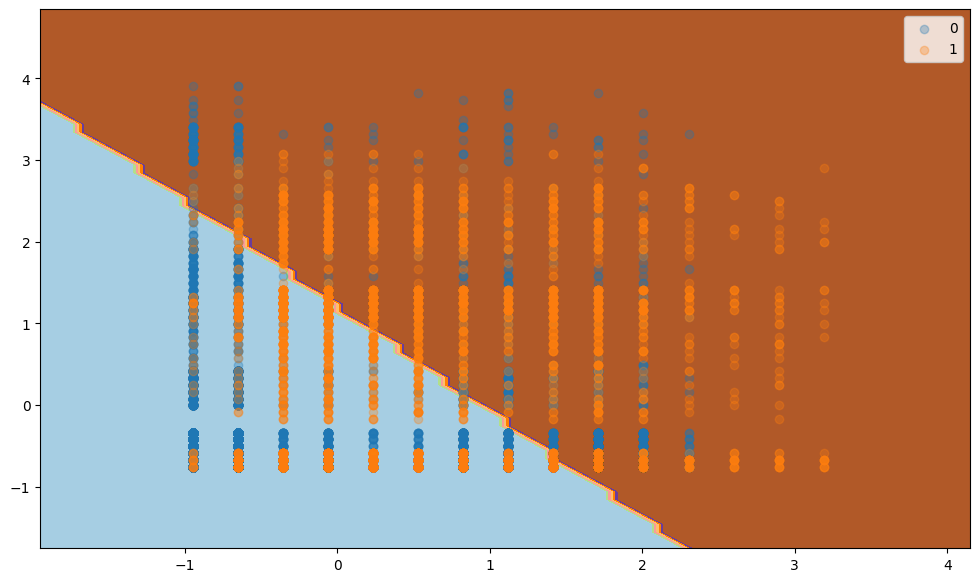

 
Our model: [10, 'l2', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



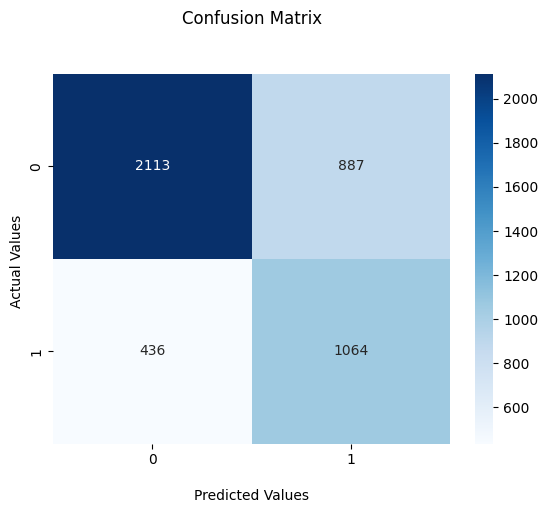

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


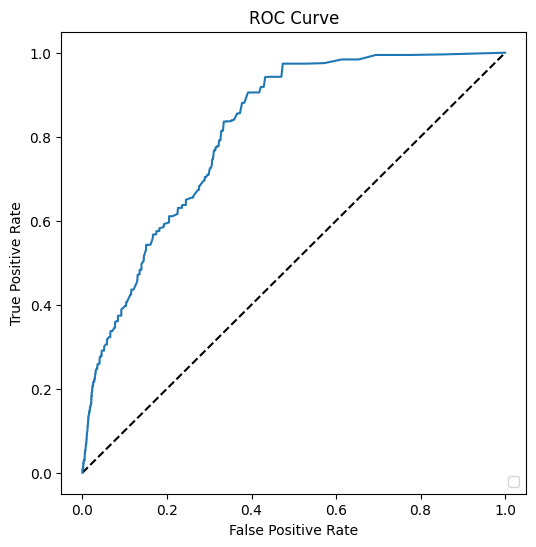

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


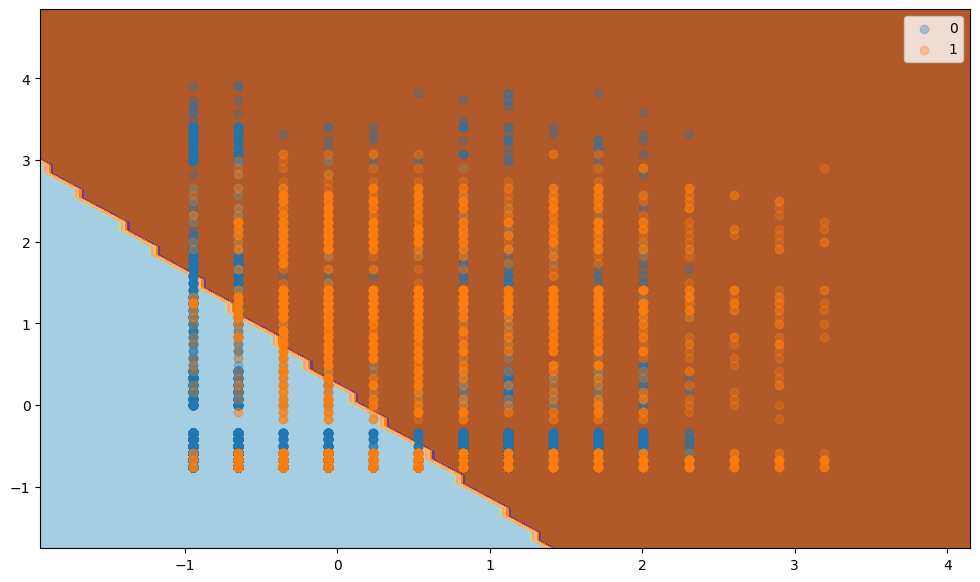

 
Our model: [10, 'l2', None]
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



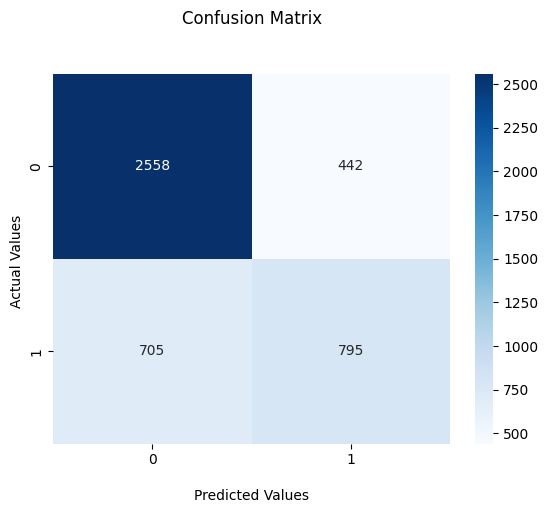

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


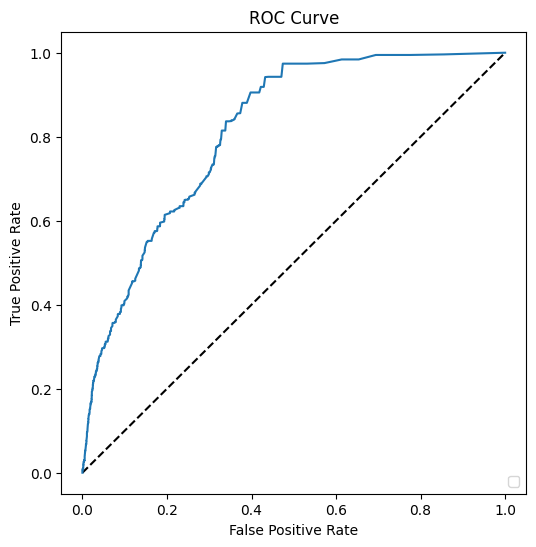

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


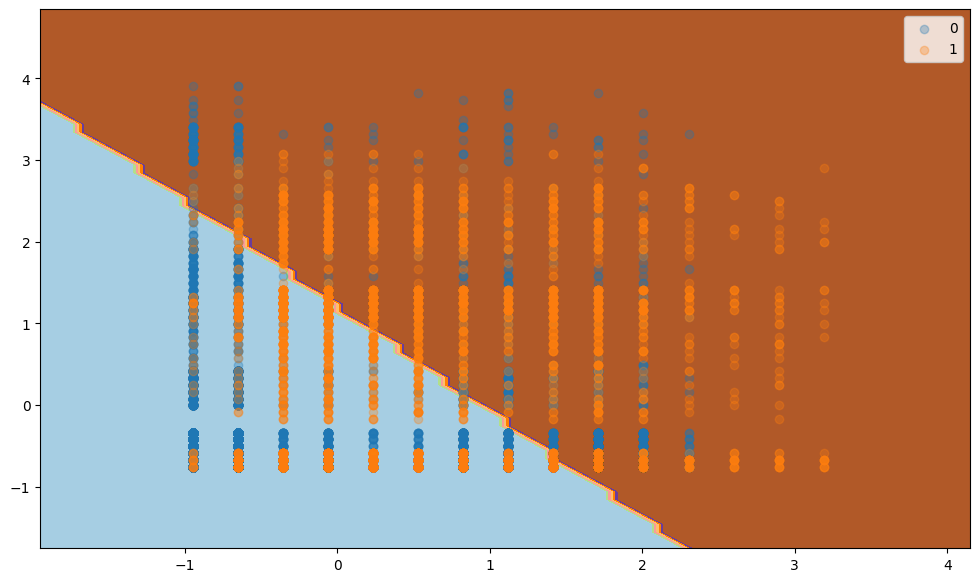

 
Our model: [100, 'l1', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



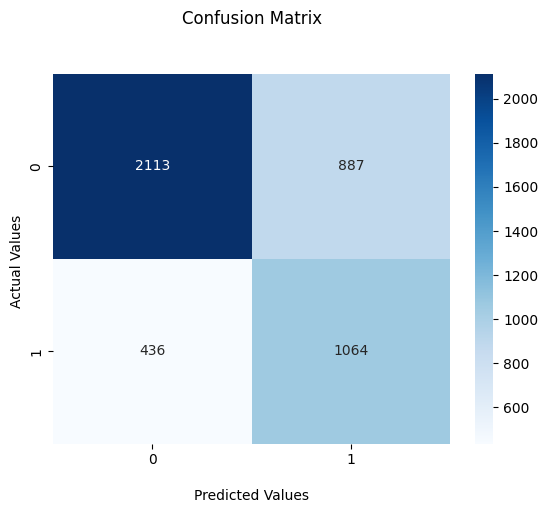

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


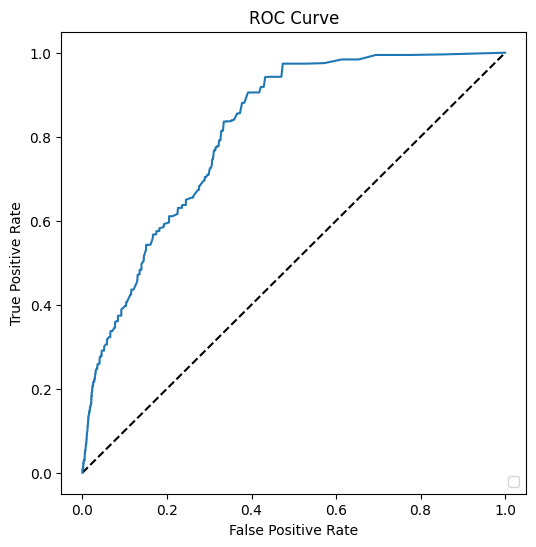

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


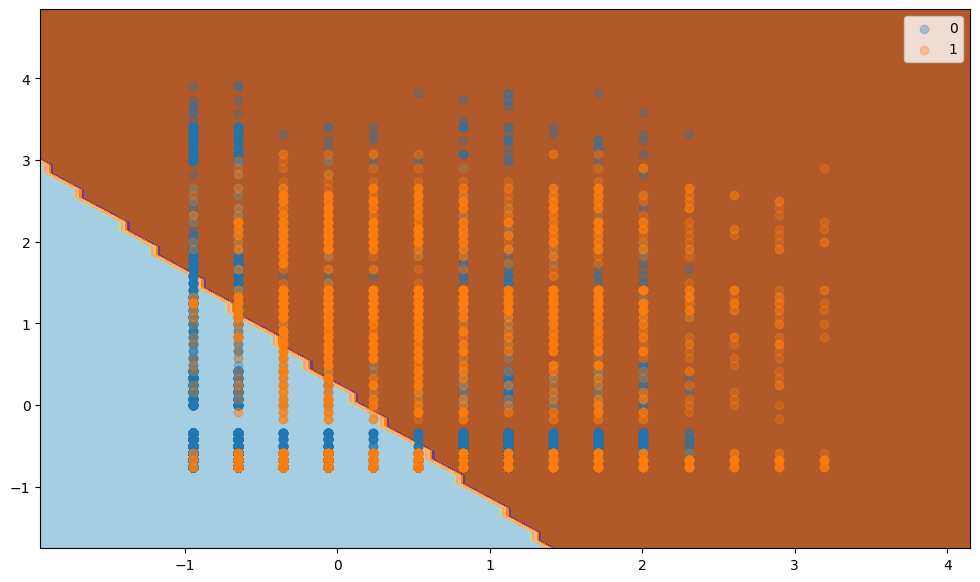

 
Our model: [100, 'l1', None]
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



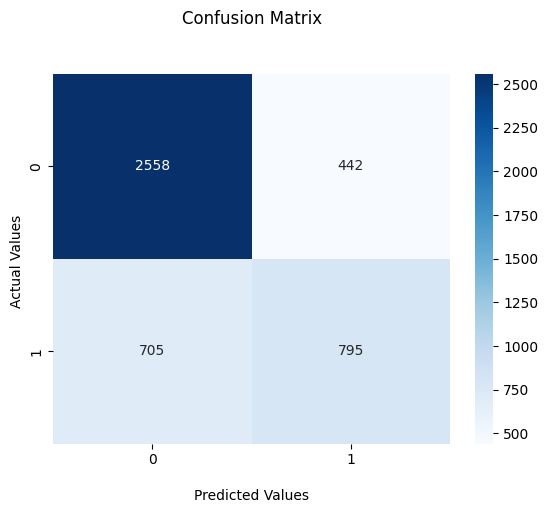

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


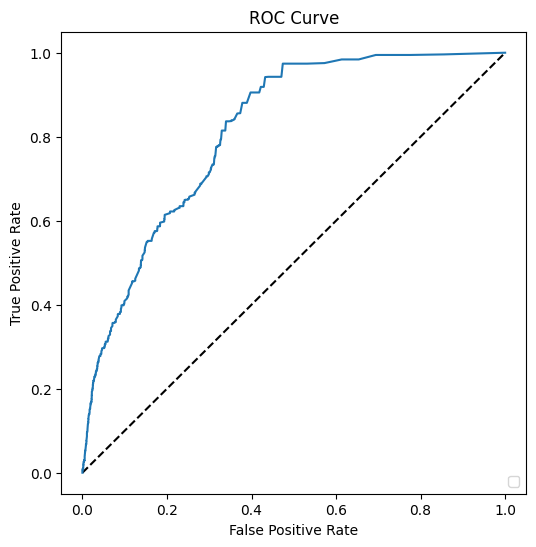

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


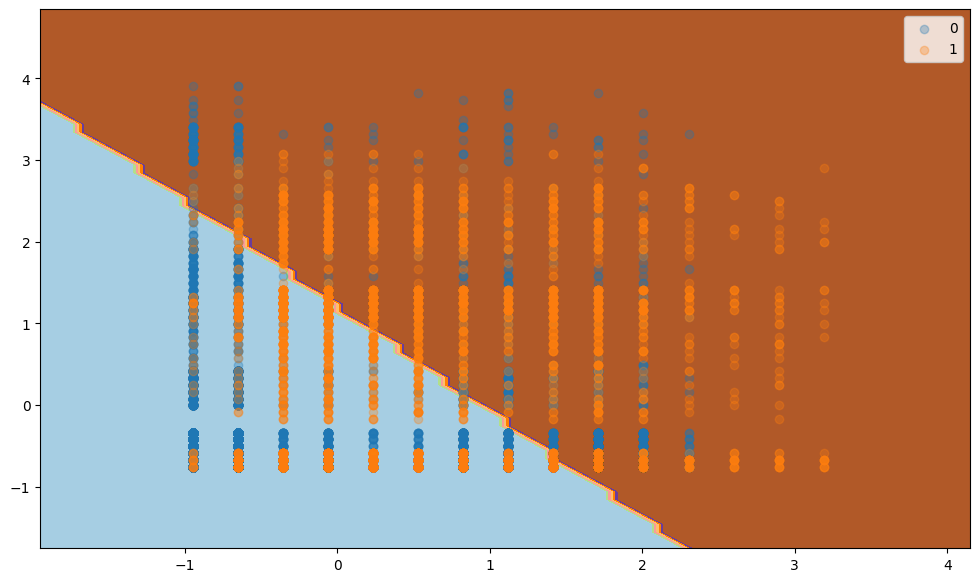

 
Our model: [100, 'l2', 'balanced']
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



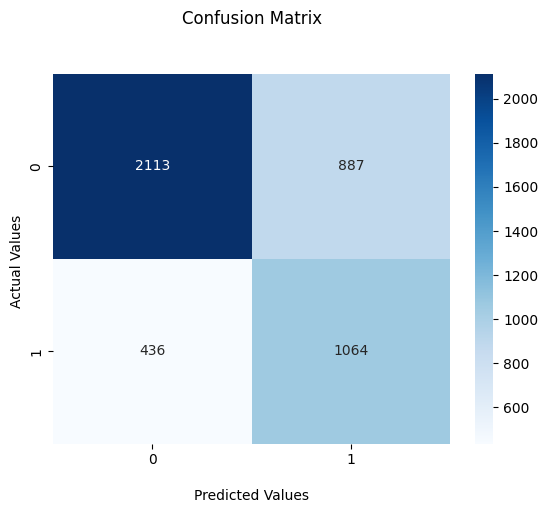

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


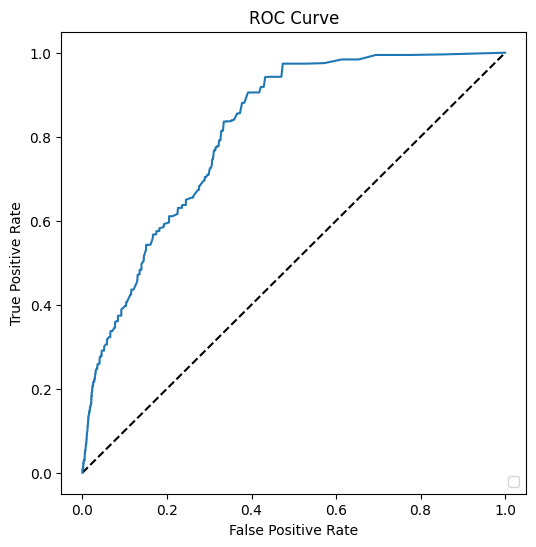

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


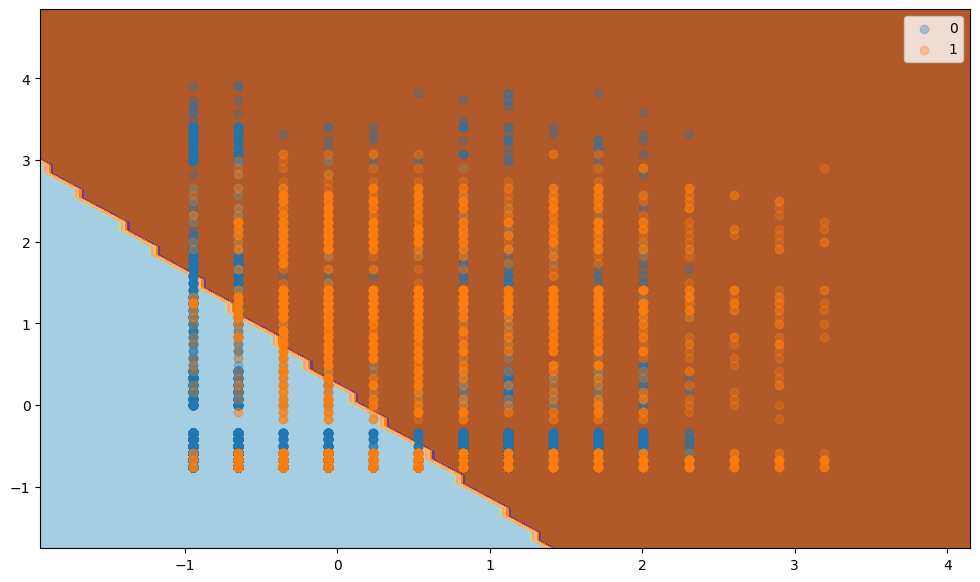

 
Our model: [100, 'l2', None]
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



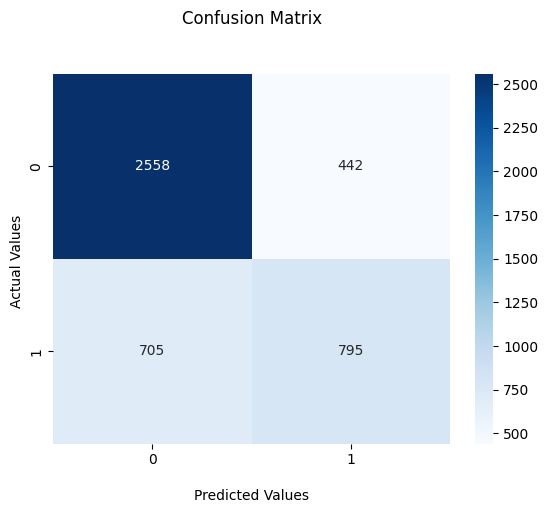

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2439054290.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


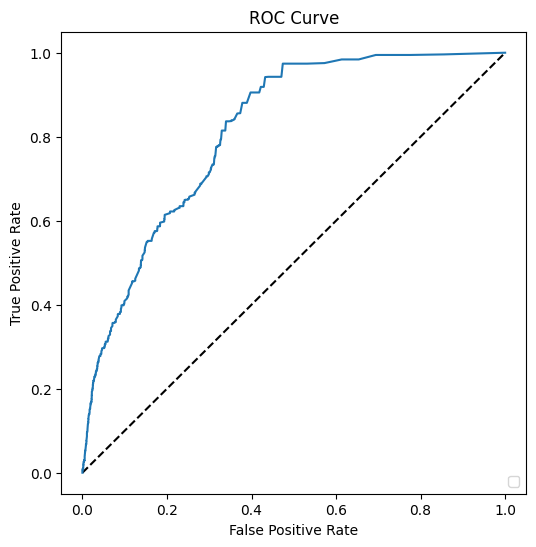

C:\Users\user\AppData\Local\Temp\ipykernel_2788\2116220769.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


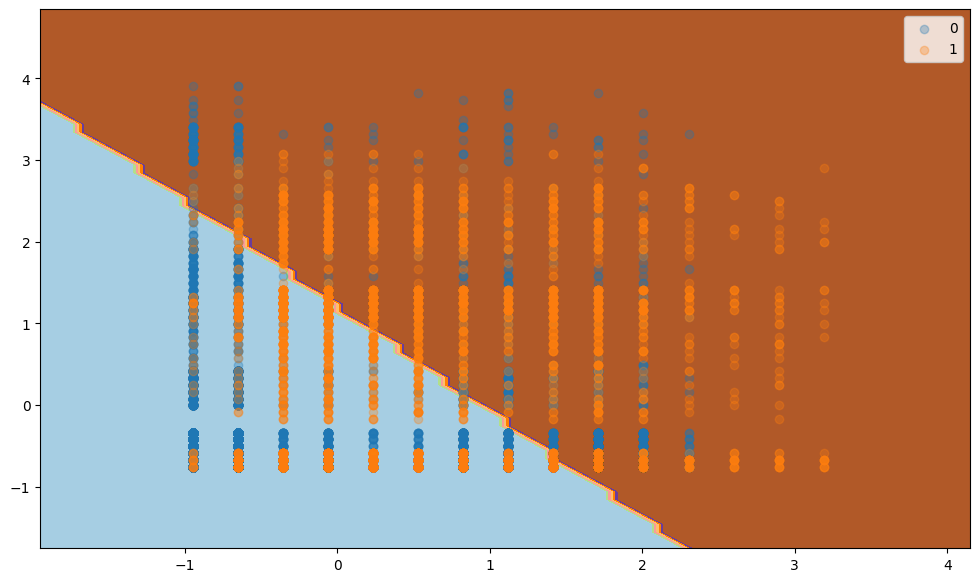

In [10]:
for model_lr,specifics in our_models:
    print('Our model:',specifics)
    calculate_metrics(model_lr, 'Logistic Regression', X_test_standardized, y_test, specifics)
    plot_classification_surface(X_train_standardized, y_train, model_lr)
    print(' ')

In [11]:
best_model = metrics_dataframe.sort_values(by=['F1_score', 'AUC'], ascending=False).iloc[0]
print("\nBest Model Configuration:")
print(best_model)


Best Model Configuration:
Model           Logistic Regression
F1_score                   0.618497
AUC                        0.816422
C                              0.01
Penalty                          l1
Class Weight               balanced
Name: 0, dtype: object


Dla naszych danych najlepsze wyniki uzyskał model o atrybutach C=0.01, penalty l1 i class weight balanced, czyli że warto ustawić wagi odwrotnie proporcjonalne do częstości występowania klas (ma to sens, jakoże osób zdrowych było 60%, a chorych 30%), silną regularyzację, zmiejszając ryzyko przeuczenia, oraz ustawić, by mniej znaczące cechy w ogóle nie wpływały one na decyzyjność modelu.